<a href="https://colab.research.google.com/github/Derinhelm/llm_parsing/blob/main/llm_parsing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Derinhelm/llm_parsing.git

Cloning into 'llm_parsing'...
remote: Enumerating objects: 702, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 702 (delta 0), reused 0 (delta 0), pack-reused 701 (from 2)
Receiving objects: 100% (702/702), 266.51 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (474/474), done.
Updating files: 100% (585/585), done.


In [ ]:
import sys
sys.path.insert(0, '/content/llm_parsing/analysis')

In [ ]:
from collections import Counter
import gc

from metrics import calculate_metrics
from read_gold import read_gold_treebank
from read_pred import LineResult, ParserSentResult, parse_results

In [ ]:
treebank_names = ['gsd', 'pud', 'taiga', 'poetry', 'syntagrus']
parser_names = [ 'llama70', 'qwen32', 'ruadapt32','tpro', 'qwen8',
                'ruadapt8hybr', 'yandexgpt8', 'tlite',
                'qwen4', 'ruadapt4',]
#parser_names = [ 'llama70', 'qwen32', 'qwen8', 'qwen4', 'ruadapt32',
#                'ruadapt8hybr','ruadapt4', 'tpro', 'tlite', 'yandexgpt8']
prompt_range = range(1, 11)
experiments = [(tr, prompt_i, parser) for tr in treebank_names
               for prompt_i in prompt_range
               for parser in parser_names ]
gold_treebanks = {}
for tr in treebank_names:
    gold_treebanks[tr] = read_gold_treebank(f'/content/llm_parsing/treebanks/ru_{tr}-ud-test.conllu')


In [ ]:
parser_names_large = ['llama70', 'qwen32', 'ruadapt32', 'tpro']
parser_names_medium = ['qwen8', 'ruadapt8hybr', 'yandexgpt8', 'tlite']
parser_names_small = ['qwen4', 'ruadapt4']

In [ ]:
pred_results = {}
uas, las = {}, {}
line_stat = {}
errors = {}
sentence_errors = {}
for tr, prompt_i, parser in experiments:
    pred_results[(tr, prompt_i, parser)] = \
        parse_results(f'/content/llm_parsing/results/{parser}/{tr}/{parser}_{tr}_2_{prompt_i}.txt')

    assert len(pred_results[(tr, prompt_i, parser)]) == len(gold_treebanks[tr])
    for s_i, gold_s in enumerate(gold_treebanks[tr]):
        pred_results[(tr, prompt_i, parser)][s_i].create_errors(gold_s)

    uas[(tr, prompt_i, parser)], las[(tr, prompt_i, parser)] = \
                calculate_metrics(gold_treebanks[tr], pred_results[(tr, prompt_i, parser)])

    line_stat[(tr, prompt_i, parser)] = [(len(sr.splitted), len(sr.normal)) for sr in pred_results[(tr, prompt_i, parser)] ]

    errors[(tr, prompt_i, parser)] = Counter(er[0] for sr in pred_results[(tr, prompt_i, parser)] for t in sr.splitted for er in t.errors)
    errors[(tr, prompt_i, parser)] += Counter(er[0] for sr in pred_results[(tr, prompt_i, parser)] for er in sr.errors)

    del pred_results[(tr, prompt_i, parser)]
    gc.collect()
    if prompt_i == 10:
      print(tr, parser)


gsd llama70
gsd qwen32
gsd ruadapt32
gsd tpro
gsd qwen8
gsd ruadapt8hybr
gsd yandexgpt8
gsd tlite
gsd qwen4
gsd ruadapt4
pud llama70
pud qwen32
pud ruadapt32
pud tpro
pud qwen8
pud ruadapt8hybr
pud yandexgpt8
pud tlite
pud qwen4
pud ruadapt4
taiga llama70
taiga qwen32
taiga ruadapt32
taiga tpro
taiga qwen8
taiga ruadapt8hybr
taiga yandexgpt8
taiga tlite
taiga qwen4
taiga ruadapt4
poetry llama70
poetry qwen32
poetry ruadapt32
poetry tpro
poetry qwen8
poetry ruadapt8hybr
poetry yandexgpt8
poetry tlite
poetry qwen4
poetry ruadapt4
syntagrus llama70
syntagrus qwen32
syntagrus ruadapt32
syntagrus tpro
syntagrus qwen8
syntagrus ruadapt8hybr
syntagrus yandexgpt8
syntagrus tlite
syntagrus qwen4
syntagrus ruadapt4


In [ ]:
len(parser_names)

10

# UAS and LAS

In [ ]:
best = Counter()
worst = Counter()
for parser in parser_names:
    for tr in treebank_names:
        u_stat = [uas[(tr, prompt_i, parser)].mean().round(2)
                  for prompt_i in prompt_range]
        order_i = sorted(list(prompt_range),
                         key=lambda x: -u_stat[x - 1])
        print(tr, parser, min(u_stat), max(u_stat), order_i[:3], order_i[-3:])
        best.update(order_i[:1])
        worst.update(order_i[-1:])
    print()

gsd llama70 0.45 0.55 [1, 7, 5] [6, 10, 9]
pud llama70 0.46 0.55 [1, 7, 5] [6, 10, 9]
taiga llama70 0.44 0.55 [5, 1, 7] [10, 6, 9]
poetry llama70 0.46 0.56 [1, 5, 7] [6, 10, 9]
syntagrus llama70 0.45 0.54 [1, 5, 7] [6, 10, 9]

gsd qwen32 0.42 0.51 [1, 5, 7] [8, 6, 9]
pud qwen32 0.41 0.51 [1, 4, 5] [3, 6, 9]
taiga qwen32 0.42 0.51 [1, 3, 5] [2, 6, 9]
poetry qwen32 0.43 0.52 [1, 5, 4] [3, 6, 9]
syntagrus qwen32 0.41 0.5 [5, 7, 1] [3, 6, 9]

gsd ruadapt32 0.31 0.49 [7, 1, 5] [2, 6, 9]
pud ruadapt32 0.31 0.52 [7, 1, 5] [10, 6, 9]
taiga ruadapt32 0.31 0.47 [7, 8, 1] [4, 6, 9]
poetry ruadapt32 0.3 0.49 [4, 7, 8] [3, 6, 9]
syntagrus ruadapt32 0.3 0.49 [7, 8, 1] [3, 6, 9]

gsd tpro 0.4 0.53 [5, 7, 1] [2, 6, 9]
pud tpro 0.38 0.54 [7, 1, 5] [10, 6, 9]
taiga tpro 0.37 0.56 [7, 5, 1] [10, 6, 9]
poetry tpro 0.38 0.56 [7, 5, 1] [10, 6, 9]
syntagrus tpro 0.37 0.53 [7, 5, 1] [10, 6, 9]

gsd qwen8 0.21 0.44 [1, 7, 4] [10, 6, 9]
pud qwen8 0.19 0.46 [1, 4, 7] [10, 6, 9]
taiga qwen8 0.27 0.45 [1, 2, 8] [1

In [ ]:
best.most_common()

[(1, 24), (7, 15), (8, 5), (5, 3), (2, 2), (4, 1)]

In [ ]:
worst.most_common()

[(9, 44), (10, 5), (2, 1)]

In [ ]:
import pandas as pd


In [ ]:
pd.DataFrame([{tr:max([uas[(tr, prompt_i, parser)].mean().round(2)
                  for prompt_i in prompt_range]) for tr in treebank_names}
                  for parser in parser_names], index=parser_names)

,gsd,pud,taiga,poetry,syntagrus
llama70,0.55,0.55,0.55,0.56,0.54
qwen32,0.51,0.51,0.51,0.52,0.50
ruadapt32,0.49,0.52,0.47,0.49,0.49
tpro,0.53,0.54,0.56,0.56,0.53
qwen8,0.44,0.46,0.45,0.48,0.44
ruadapt8hybr,0.38,0.40,0.41,0.44,0.39
yandexgpt8,0.43,0.42,0.43,0.46,0.42
tlite,0.37,0.37,0.38,0.41,0.37
qwen4,0.41,0.42,0.43,0.47,0.42
ruadapt4,0.33,0.33,0.34,0.38,0.34


In [ ]:
pd.DataFrame([{tr:max([las[(tr, prompt_i, parser)].mean().round(2)
                  for prompt_i in prompt_range]) for tr in treebank_names}
                  for parser in parser_names], index=parser_names)

,gsd,pud,taiga,poetry,syntagrus
llama70,0.46,0.47,0.45,0.47,0.45
qwen32,0.41,0.42,0.42,0.44,0.40
ruadapt32,0.35,0.39,0.36,0.40,0.36
tpro,0.40,0.40,0.43,0.44,0.40
qwen8,0.31,0.33,0.33,0.36,0.32
ruadapt8hybr,0.26,0.27,0.29,0.32,0.27
yandexgpt8,0.30,0.30,0.30,0.35,0.30
tlite,0.23,0.23,0.24,0.28,0.24
qwen4,0.23,0.24,0.26,0.30,0.25
ruadapt4,0.17,0.17,0.20,0.24,0.19


In [ ]:
tr, prompt_i, parser = ('syntagrus', 10, 'yandexgpt8')

In [ ]:
import matplotlib.pyplot as plt

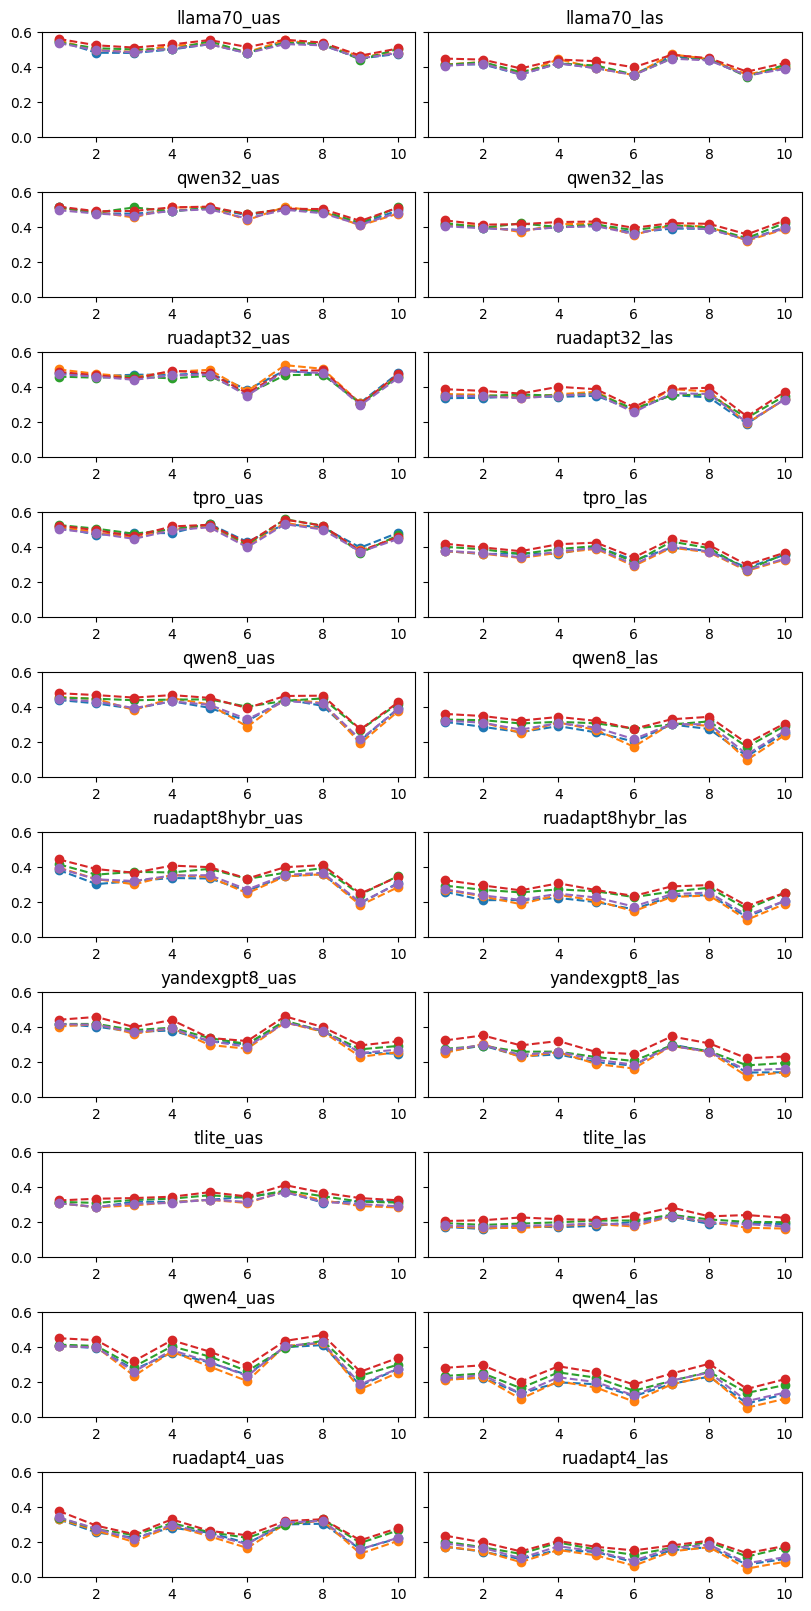

In [ ]:
f, axs = plt.subplots(len(parser_names), 2, figsize=(8, 16),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names):
    for tr in treebank_names:
        axs[parser_i][0].plot(prompt_range, [uas[(tr, prompt_i, parser)].mean()
            for prompt_i in prompt_range], 'o--')
    axs[parser_i][0].set_title(f"{parser}_uas")

    for tr in treebank_names:
        axs[parser_i][1].plot(prompt_range, [las[(tr, prompt_i, parser)].mean()
            for prompt_i in prompt_range], 'o--')
    axs[parser_i][1].set_title(f"{parser}_las")
    axs[parser_i][1].set_ylim(0, 0.6)

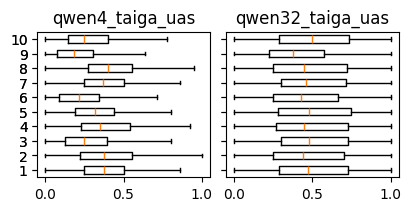

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(4, 2),
                      constrained_layout=True, sharey=True)
tr, parser = 'taiga', 'qwen4'
axs[0].boxplot([uas[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
axs[0].set_title(f"{parser}_{tr}_uas")

tr, parser = 'taiga', 'qwen32'
axs[1].boxplot([uas[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
axs[1].set_title(f"{parser}_{tr}_uas")
plt.savefig("boxplot_example.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

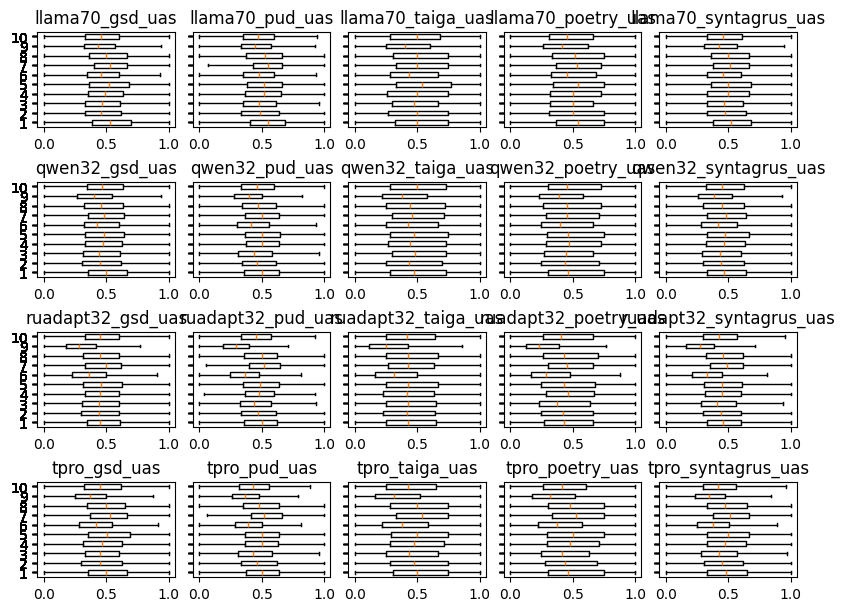

In [ ]:
f, axs = plt.subplots(len(parser_names_large), len(treebank_names), figsize=(8, 6),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names_large):
    for tr_i, tr in enumerate(treebank_names):
        axs[parser_i][tr_i].boxplot([uas[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
        axs[parser_i][tr_i].set_title(f"{parser}_{tr}_uas")
plt.savefig("boxplot_large_uas.eps", format='eps', dpi=300, bbox_inches='tight')

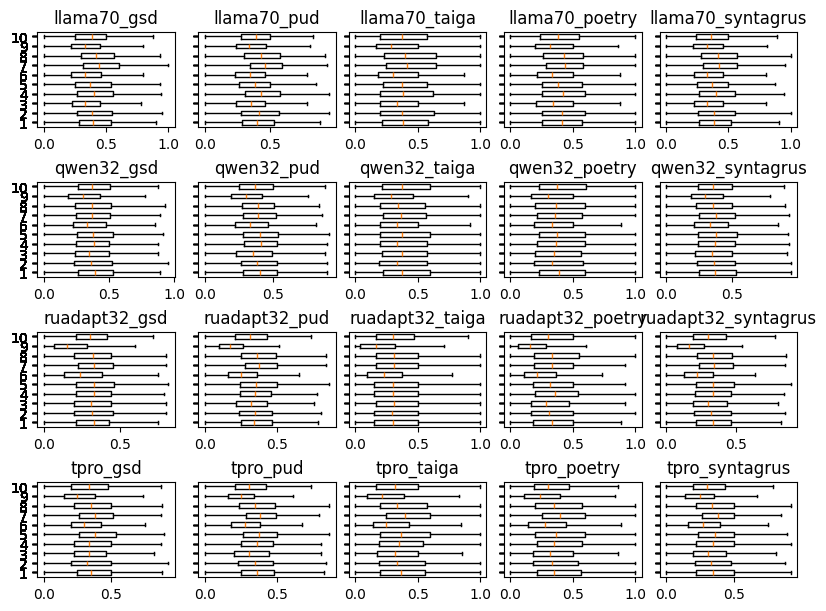

In [ ]:
f, axs = plt.subplots(len(parser_names_large), len(treebank_names), figsize=(8, 6),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names_large):
    for tr_i, tr in enumerate(treebank_names):
        axs[parser_i][tr_i].boxplot([las[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
        axs[parser_i][tr_i].set_title(f"{parser}_{tr}")
plt.savefig("boxplot_large_las.eps", format='eps', dpi=300, bbox_inches='tight')

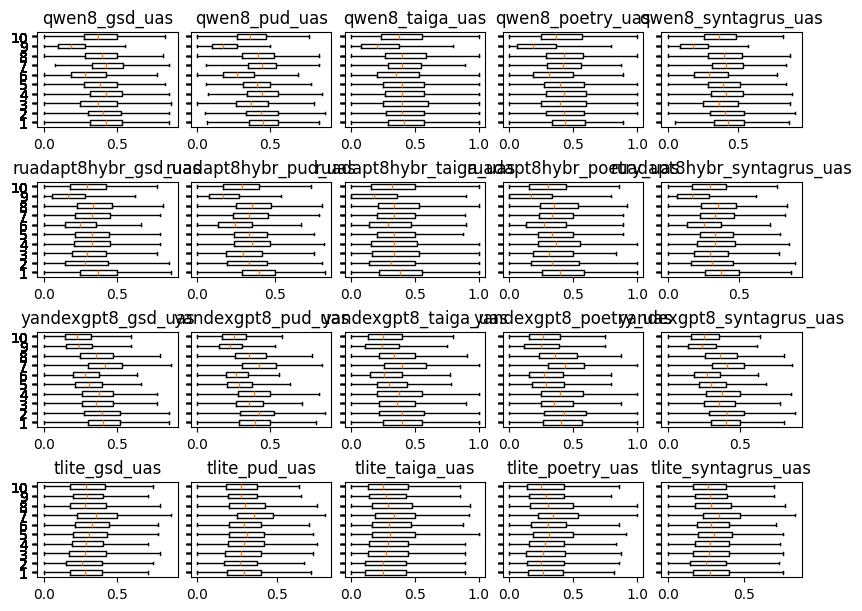

In [ ]:
f, axs = plt.subplots(len(parser_names_medium), len(treebank_names), figsize=(8, 6),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names_medium):
    for tr_i, tr in enumerate(treebank_names):
        axs[parser_i][tr_i].boxplot([uas[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
        axs[parser_i][tr_i].set_title(f"{parser}_{tr}_uas")
plt.savefig("boxplot_medium_uas.eps", format='eps', dpi=300, bbox_inches='tight')

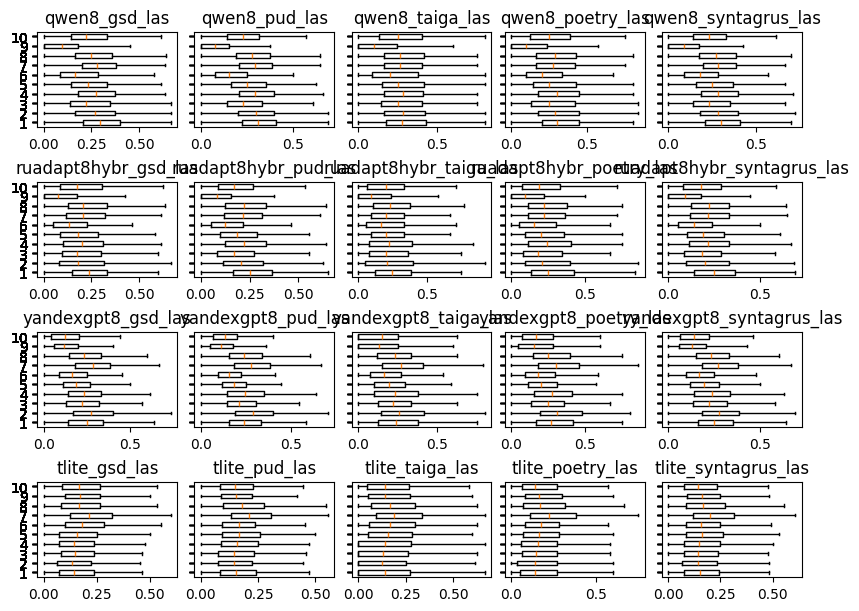

In [ ]:
f, axs = plt.subplots(len(parser_names_medium), len(treebank_names), figsize=(8, 6),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names_medium):
    for tr_i, tr in enumerate(treebank_names):
        axs[parser_i][tr_i].boxplot([las[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
        axs[parser_i][tr_i].set_title(f"{parser}_{tr}_las")
plt.savefig("boxplot_medium_las.eps", format='eps', dpi=300, bbox_inches='tight')

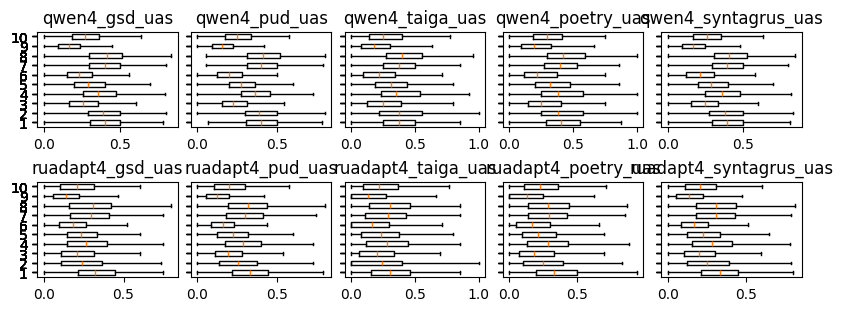

In [ ]:
f, axs = plt.subplots(len(parser_names_small), len(treebank_names), figsize=(8, 3),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names_small):
    for tr_i, tr in enumerate(treebank_names):
        axs[parser_i][tr_i].boxplot([uas[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
        axs[parser_i][tr_i].set_title(f"{parser}_{tr}_uas")
plt.savefig("boxplot_small_uas.eps", format='eps', dpi=300, bbox_inches='tight')

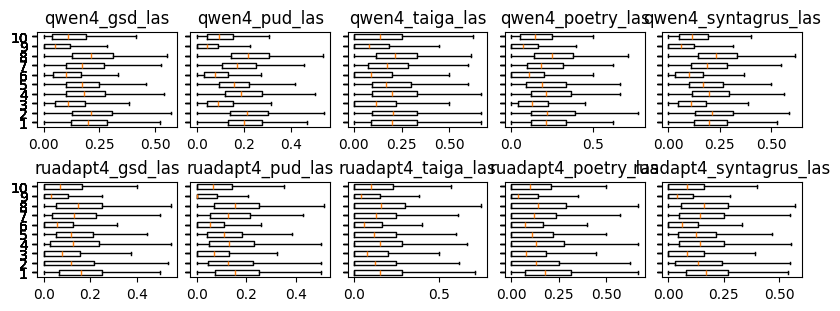

In [ ]:
f, axs = plt.subplots(len(parser_names_small), len(treebank_names), figsize=(8, 3),
                      constrained_layout=True, sharey=True)
for parser_i, parser in enumerate(parser_names_small):
    for tr_i, tr in enumerate(treebank_names):
        axs[parser_i][tr_i].boxplot([las[(tr, prompt_i, parser)]
            for prompt_i in prompt_range], vert=False, showfliers=False)
        axs[parser_i][tr_i].set_title(f"{parser}_{tr}_las")
plt.savefig("boxplot_small_las.eps", format='eps', dpi=300, bbox_inches='tight')

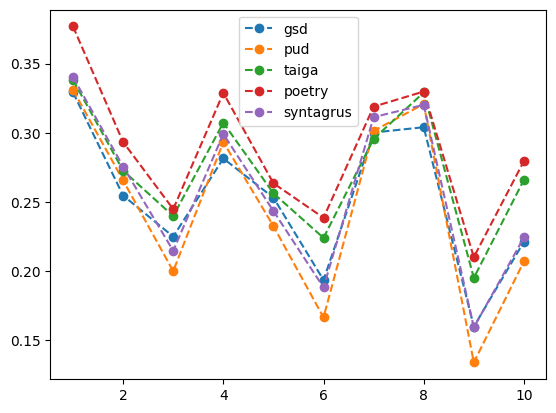

In [ ]:
for tr in treebank_names:
  plt.plot(prompt_range, [uas[(tr, prompt_i, parser)].mean() for prompt_i in prompt_range], 'o--', label=tr)#marker='o', linestyle='-')
plt.legend()
plt.show()

# Extra lines

In [ ]:
extra_line_dict = {}
for expir_i in experiments:
    x = pd.Series(((all_line - right_line) / right_line if right_line != 0 else -1) for (all_line, right_line) in line_stat[expir_i])
    extra_line_dict[expir_i] = {}
    extra_line_dict[expir_i]['0'] = sum(x == 0)
    extra_line_dict[expir_i]['(0, 1]'] = sum((x > 0) & (x <= 1))
    extra_line_dict[expir_i]['(1, 2]'] = sum((x > 1) & (x <= 2))
    extra_line_dict[expir_i]['2+'] = sum(x > 2)
    extra_line_dict[expir_i]['None'] = sum(x == -1)

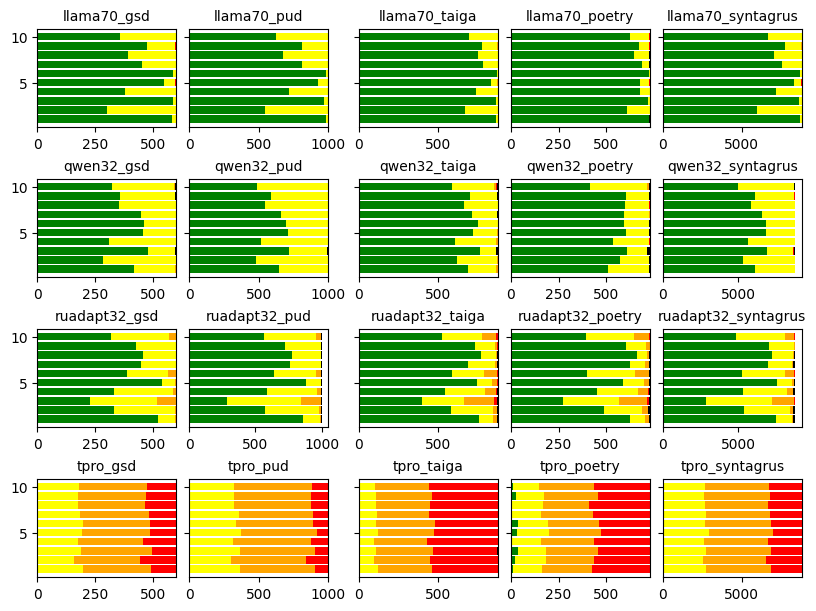

In [ ]:
import numpy as np

f, axs = plt.subplots(len(parser_names[:4]), len(treebank_names), figsize=(8, 6),
                      constrained_layout=True, sharey=True)
#plt.subplots_adjust(wspace=0.3, hspace=0.4)
colors = ['green', 'yellow', 'orange', 'red', 'black']
for parser_i, parser in enumerate(parser_names[:4]):#parser_names[0:1] + parser_names[1:5] + parser_names[-1:] + parser_names[5:7]):
  for tr_i, tr in enumerate(treebank_names):
    axs[parser_i][tr_i].set_title(f"{parser}_{tr}".replace("yandexgpt", "ygpt").replace('ruadapt8hybr', 'ruadapt8'), fontdict={'fontsize': 10})
    left = np.zeros(len(prompt_range))
    for k_i, k in enumerate(['0', '(0, 1]', '(1, 2]', '2+', 'None']):
      new_values = np.array([extra_line_dict[(tr, prompt_i, parser)][k] for prompt_i in prompt_range])
      axs[parser_i][tr_i].barh(prompt_range, new_values, left=left, color=colors[k_i])
      left += new_values
plt.savefig("extra_lines1.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

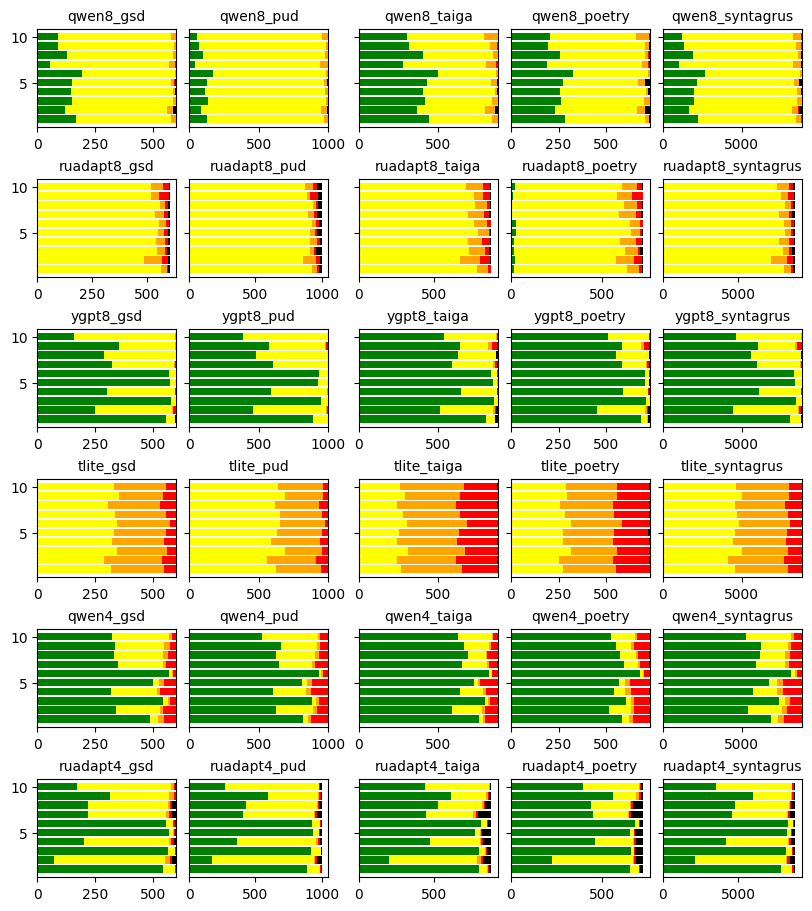

In [ ]:
import numpy as np

f, axs = plt.subplots(len(parser_names[4:]), len(treebank_names), figsize=(8, 9),
                      constrained_layout=True, sharey=True)
#plt.subplots_adjust(wspace=0.3, hspace=0.4)
colors = ['green', 'yellow', 'orange', 'red', 'black']
for parser_i, parser in enumerate(parser_names[4:]):#parser_names[0:1] + parser_names[1:5] + parser_names[-1:] + parser_names[5:7]):
  for tr_i, tr in enumerate(treebank_names):
    axs[parser_i][tr_i].set_title(f"{parser}_{tr}".replace("yandexgpt", "ygpt").replace('ruadapt8hybr', 'ruadapt8'), fontdict={'fontsize': 10})
    left = np.zeros(len(prompt_range))
    for k_i, k in enumerate(['0', '(0, 1]', '(1, 2]', '2+', 'None']):
      new_values = np.array([extra_line_dict[(tr, prompt_i, parser)][k] for prompt_i in prompt_range])
      axs[parser_i][tr_i].barh(prompt_range, new_values, left=left, color=colors[k_i])
      left += new_values
plt.savefig("extra_lines2.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

# Ошибки в предсказанных данных

In [ ]:
for parser in parser_names:
  print(parser, end=" & ")
  for tr in treebank_names:
    values = [errors[(tr, prompt_i, parser)]['Form set error'] / len(gold_treebanks[tr]) for prompt_i in prompt_range]
    print(f"{min(values) * 100:.0f}\%--{max(values) * 100:.0f}\%", end=" & ")
  print()

llama70 & 6\%--52\% & 5\%--48\% & 2\%--26\% & 2\%--19\% & 4\%--35\% & 
qwen32 & 24\%--54\% & 29\%--54\% & 12\%--29\% & 11\%--21\% & 21\%--41\% & 
ruadapt32 & 23\%--53\% & 13\%--42\% & 8\%--28\% & 7\%--19\% & 12\%--35\% & 
tpro & 34\%--63\% & 38\%--61\% & 19\%--36\% & 20\%--30\% & 29\%--47\% & 
qwen8 & 4\%--17\% & 3\%--12\% & 2\%--9\% & 1\%--10\% & 2\%--12\% & 
ruadapt8hybr & 39\%--76\% & 37\%--73\% & 24\%--61\% & 25\%--57\% & 33\%--67\% & 
yandexgpt8 & 18\%--77\% & 18\%--66\% & 8\%--45\% & 11\%--43\% & 15\%--55\% & 
tlite & 24\%--54\% & 25\%--45\% & 20\%--30\% & 16\%--24\% & 22\%--36\% & 
qwen4 & 3\%--43\% & 4\%--44\% & 4\%--28\% & 2\%--22\% & 4\%--36\% & 
ruadapt4 & 37\%--94\% & 37\%--90\% & 27\%--84\% & 26\%--78\% & 32\%--84\% & 


<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-1542512610.py:5: SyntaxWarning: invalid escape sequence '\%'
  print(f"{min(values) * 100:.0f}\%--{max(values) * 100:.0f}\%", end=" & ")
/tmp/ipython-input-1542512610.py:5: SyntaxWarning: invalid escape sequence '\%'
  print(f"{min(values) * 100:.0f}\%--{max(values) * 100:.0f}\%", end=" & ")


In [ ]:
errors[(tr, prompt_i, parser)]['Form set error']

6180

In [ ]:
for tr in treebank_names:
  for parser in parser_names:
    print(tr, parser,
      [round(errors[(tr, prompt_i, parser)]['Form set error'] / len(gold_treebanks[tr]), 2) for prompt_i in prompt_range])
  print()

gsd llama70 [0.07, 0.52, 0.06, 0.4, 0.14, 0.06, 0.27, 0.38, 0.25, 0.42]
gsd qwen32 [0.31, 0.54, 0.24, 0.48, 0.31, 0.29, 0.31, 0.47, 0.44, 0.39]
gsd ruadapt32 [0.27, 0.53, 0.23, 0.48, 0.25, 0.25, 0.38, 0.38, 0.37, 0.43]
gsd tpro [0.37, 0.63, 0.35, 0.55, 0.34, 0.39, 0.41, 0.52, 0.48, 0.48]
gsd qwen8 [0.08, 0.14, 0.07, 0.08, 0.09, 0.04, 0.06, 0.17, 0.1, 0.07]
gsd ruadapt8hybr [0.45, 0.76, 0.4, 0.63, 0.42, 0.39, 0.59, 0.57, 0.53, 0.66]
gsd yandexgpt8 [0.21, 0.64, 0.18, 0.58, 0.19, 0.19, 0.55, 0.57, 0.47, 0.77]
gsd tlite [0.31, 0.41, 0.27, 0.36, 0.29, 0.24, 0.29, 0.54, 0.39, 0.31]
gsd qwen4 [0.12, 0.41, 0.05, 0.43, 0.09, 0.03, 0.35, 0.41, 0.41, 0.43]
gsd ruadapt4 [0.45, 0.94, 0.4, 0.78, 0.4, 0.37, 0.76, 0.79, 0.63, 0.8]

pud llama70 [0.05, 0.48, 0.06, 0.3, 0.12, 0.05, 0.21, 0.36, 0.2, 0.39]
pud qwen32 [0.34, 0.54, 0.29, 0.47, 0.33, 0.32, 0.37, 0.49, 0.43, 0.4]
pud ruadapt32 [0.16, 0.42, 0.13, 0.34, 0.18, 0.14, 0.27, 0.29, 0.29, 0.31]
pud tpro [0.41, 0.61, 0.38, 0.51, 0.4, 0.45, 0.44, 0.54, 

In [ ]:
errors[(tr, prompt_i, parser)]

Counter({'Wrong relation': 15333,
         'Wrong len': 13467,
         'Not digit id': 255,
         'Not digit parent_id': 729,
         'Wrong form': 81,
         'Parent_id set error': 8657,
         'Relation set error': 8689,
         'Form set error': 6180,
         'Id set error': 5503})

In [ ]:
tr, prompt_i, parser = ('syntagrus', 1, 'tpro')

r = parse_results(f'/content/llm_parsing/results/{parser}/{tr}/{parser}_{tr}_2_{prompt_i}.txt')
for s_i, gold_s in enumerate(gold_treebanks[tr]):
    r[s_i].create_errors(gold_s)

In [ ]:
print(r[516].original_s)


Вот предложение в формате CONLL с 26 строками, строго следуя порядку токенов и требованиям:

```
1	Дирекция	_	_	_	_	2	nsubj	_	_
2	была	_	_	_	_	0	root	_	_
3	особым	_	_	_	_	4	amod	_	_
4	миром	_	_	_	_	2	pobj	_	_
5	,	_	_	_	_	4	punct	_	_
6	Олимпом	_	_	_	_	4	appos	_	_
7	,	_	_	_	_	6	punct	_	_
8	в	_	_	_	_	10	case	_	_
9	который	_	_	_	_	10	nmod	_	_
10	входил	_	_	_	_	2	advcl	_	_
11	Илья	_	_	_	_	10	nsubj	_	_
12	Ильич	_	_	_	_	11	flat:name	_	_
13	если	_	_	_	_	10	mark	_	_
14	когда-либо	_	_	_	_	13	advmod	_	_
15	и	_	_	_	_	13	cop	_	_
16	входил	_	_	_	_	15	ccomp	_	_
17	,	_	_	_	_	10	punct	_	_
18	то	_	_	_	_	20	mark	_	_
19	не	_	_	_	_	20	advmod	_	_
20	иначе	_	_	_	_	2	advcl	_	_
21	,	_	_	_	_	20	punct	_	_
22	как	_	_	_	_	24	mark	_	_
23	непроизвольно	_	_	_	_	24	advmod	_	_
24	стушевываясь	_	_	_	_	20	advcl	_	_
25	и	_	_	_	_	24	case	_	_
26	теряясь	_	_	_	_	24	conj	_	_
27	.	_	_	_	_	2	punct	_	_
```

**Исправление:**  
В вашем списке токенов 26 элементов, но в предложении есть ещё точка (27-й токен). Чтобы строго соответ

In [ ]:
print([t.form for t in r[516].normal])
print([t['form'] for t in gold_treebanks[tr][516]])

['Дирекция', 'была', 'особым', 'миром', ',', 'Олимпом', ',', 'в', 'который', 'входил', 'Илья', 'если', 'когда-либо', 'и', 'входил', ',', 'то', 'не', 'иначе', ',', 'как', 'непроизвольно', 'стушевываясь', 'и', 'теряясь', '.', 'Дирекция', 'была', 'особым', 'миром', ',', 'Олимпом', ',', 'в', 'который', 'входил', 'Илья', 'если', 'когда-либо', 'и', 'входил', ',', 'то', 'не', 'иначе', ',', 'как', 'непроизвольно', 'стушевываясь', 'и', 'теряясь']
['Дирекция', 'была', 'особым', 'миром', ',', 'Олимпом', ',', 'в', 'который', 'Илья', 'Ильич', 'если', 'когда-либо', 'и', 'входил', ',', 'то', 'не', 'иначе', ',', 'как', 'непроизвольно', 'стушевываясь', 'и', 'теряясь', '.']


In [ ]:
print([t.form for t in r[837].normal])
print([t['form'] for t in gold_treebanks[tr][837]])

['На', 'доработку', 'дали', 'три', 'недели', '.']
['На', 'доработку', 'проекта', 'дали', 'три', 'недели', '.']


In [ ]:
parser

'ruadapt4'

In [ ]:
732, 837

In [ ]:
start_i = 800
[(s_i + start_i, er, ' '.join(t['form'] for t in gold_treebanks[tr][s_i + start_i]))
  for s_i, s in enumerate(r[start_i:start_i + 50]) for er in s.errors if er[0] == 'Form set error' if len(er[1][1]) == 0]

[(802,
  ('Form set error', (('есть',), ())),
  'Только те места , которые есть в данном регионе .'),
 (808,
  ('Form set error', (('Гимпельсон',), ())),
  'Службе занятости можно поручить заткнуть низкоквалифицированную дыру в штатном расписании , - рассказывает Владимир Гимпельсон .'),
 (815,
  ('Form set error', (('ее',), ())),
  'Но ее возможности ограничены бизнес - климатом в стране " , - завершил эксперт .'),
 (816,
  ('Form set error', (('пособия',), ())),
  'Сейчас размер пособия по безработице в Москве составляет от 720 до 2880 руб .'),
 (817,
  ('Form set error', (('пособия',), ())),
  'Средний размер пособия - 1153 руб .'),
 (818,
  ('Form set error', (('25 280',), ())),
  'При этом прожиточный минимум по городу составляет 6563 руб. , а средняя заработная плата 25 280 руб .'),
 (823,
  ('Form set error', (('проведенное', 'годах', 'кафедрой'), ())),
  'Одно из социологических исследований ( проведенное в 1999 - 2001 годах кафедрой социологии и психологии государственной служ

In [ ]:
r[500].normal

In [ ]:
[(s_i, er, ' '.join(t['form'] for t in gold_treebanks[tr][s_i]))
  for s_i, s in enumerate(r) for er in s.errors if er[0] == 'Form set error'
  and len(er[1][0]) > 0 and  len(er[1][1]) / len(er[1][0]) > 2]

[(177,
  ('Form set error',
   (('сегодня', 'получена', 'накачка', 'было', 'присутствовал'),
    ('Ведущий',
     'схватился',
     'за',
     'волосы',
     ':',
     'именно',
     'была',
     'от',
     'дирекции',
     ',',
     ',',
     'чтобы',
     'не',
     'накладок',
     'ибо',
     'в',
     'зале',
     'высокий',
     'иностранный',
     'гость',
     '.'))),
  'Ведущий схватился за волосы : именно сегодня была получена накачка от дирекции , чтобы не было накладок , ибо в зале присутствовал высокий иностранный гость .'),
 (211,
  ('Form set error',
   (('успокоился',),
    ('Но',
     'Но',
     'ребра',
     'ребра',
     'были',
     'были',
     'целы',
     'целы',
     ',',
     ',',
     'и',
     'и',
     'он',
     '.',
     '.'))),
  'Но ребра были целы , и он успокоился .'),
 (269, ('Form set error', (('А',), ('-', '!', '.', '.'))), '- А ! . .'),
 (390,
  ('Form set error',
   (('твоя',),
    ('Он',
     'задохнулся',
     'от',
     'боли',
     'в',
     '